# Use model determined by gridsearch and apply to ABCD data

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
import os


import scipy.stats as scipystats
from scipy.stats import pearsonr

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, mean_squared_error


import xgboost as xgb


import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats as stats 
import statsmodels.stats.stattools as stools
from statsmodels.graphics.regressionplots import *
from tabulate import tabulate
from prettytable import PrettyTable

In [2]:
sns.set_style({'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 #'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True})

In [3]:
sns.set_context({'font.size': 17.0,
 'axes.labelsize': 'medium',
 'axes.titlesize': 'large',
 'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium',
 'legend.fontsize': 'medium',
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0,
 'legend.title_fontsize': None})

In [4]:
plotdir = 'Plots\\'

## Skip to chapter "Load combined dataset" 

In [5]:
BAGandMenarche = pd.read_csv('processedData\\BAGandMenarche.csv')

In [6]:
X = BAGandMenarche['interview_age_M1']
y = BAGandMenarche['BAG']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

#print(results.summary())
# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Variable", "Coefficient", "Std. Error", "t-value", "p-value"]

# Iterate over coefficients and add rows to the table
for idx, coef in enumerate(results.params):
    row = [
        f" {results.params.index[idx]}",
        "{:.4f}".format(coef),
        "{:.4f}".format(results.bse[idx]),
        "{:.4f}".format(results.tvalues[idx]),
        "{:.4f}".format(results.pvalues[idx])
    ]
    table.add_row(row)

# Print the table
print(table)

+-------------------+-------------+------------+----------+---------+
|      Variable     | Coefficient | Std. Error | t-value  | p-value |
+-------------------+-------------+------------+----------+---------+
|        const      |   91.8317   |   6.0506   | 15.1773  |  0.0000 |
|  interview_age_M1 |   -0.7257   |   0.0423   | -17.1672 |  0.0000 |
+-------------------+-------------+------------+----------+---------+


In [7]:
BAGandMenarche['BAG_resids'] = results.resid

In [8]:
scannerdata = pd.read_csv('ABCDTabular\\abcd_mri01.txt',sep='\s+')
scannerdata = scannerdata.drop(index = 0)

In [9]:
scanred = scannerdata.loc[scannerdata['subjectkey'].isin(BAGandMenarche['subjectkey'])]

In [10]:
scanred = scanred[scanred['eventname'] == '2_year_follow_up_y_arm_1']

In [11]:
scanner = scanred[['subjectkey', 'mri_info_deviceserialnumber']].copy()

In [12]:
BAGandMenarchescanner = BAGandMenarche.merge(scanner, how = 'outer', on = 'subjectkey')

In [13]:
BAGandMenDummies = pd.get_dummies(BAGandMenarchescanner, columns=['mri_info_deviceserialnumber'], drop_first=True, dtype = int)

In [14]:
BAGandMenDummies = BAGandMenDummies.merge(scanner, how = 'outer', on = 'subjectkey')

In [15]:
BAGandMenDummies.rename(columns={'mri_info_deviceserialnumber': 'scanner','interview_age_M1': 'age'}, inplace = True)

In [16]:
BAGandMenDummies.to_csv('processedData\\BainAgePlusScannerFemale2301.csv', index = False)

In [17]:
dummies1 = BAGandMenDummies.filter(regex=".*mri_info_deviceserialnumber.*").columns.to_list()
additionalcolumns = ['age']
dummies1.extend(additionalcolumns)

In [18]:
X = BAGandMenDummies[dummies1]
y = BAGandMenDummies['BAG']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results1 = model.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                    BAG   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     13.88
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.20e-47
Time:                        11:46:15   Log-Likelihood:                -2271.2
No. Observations:                 650   AIC:                             4598.
Df Residuals:                     622   BIC:                             4724.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [19]:
BAGandMenDummies['BAGresidAgeScanner'] = results1.resid

In [20]:
BAGandMenDummies.rename(columns={'prob post': "probsPost"}, inplace = True)

In [21]:
X = BAGandMenDummies[dummies1]
y = BAGandMenDummies['probsPost']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results2 = model.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              probsPost   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.637
Date:                Tue, 20 Feb 2024   Prob (F-statistic):             0.0231
Time:                        11:46:15   Log-Likelihood:                -80.615
No. Observations:                 650   AIC:                             217.2
Df Residuals:                     622   BIC:                             342.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [22]:
BAGandMenDummies['ProbsPostresidAgeScanner'] = results2.resid

In [23]:
X = BAGandMenDummies['ProbsPostresidAgeScanner']
y = BAGandMenDummies['BAGresidAgeScanner']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     BAGresidAgeScanner   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     61.77
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.61e-14
Time:                        11:46:15   Log-Likelihood:                -2241.6
No. Observations:                 650   AIC:                             4487.
Df Residuals:                     648   BIC:                             4496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [24]:
menarcheAge = pd.read_csv('processedData\\relevantMenarcheData2year.csv')

In [25]:
menarcheAge.columns

Index(['collection_id', 'abcd_ypdms01_id', 'dataset_id', 'subjectkey',
       'src_subject_id', 'interview_date', 'interview_age', 'sex', 'eventname',
       'pds_sex_y', 'pds_ht2_y', 'pds_skin2_y', 'pds_bdyhair_y', 'pds_f4_2_y',
       'pds_f5_y', 'pds_f6_y', 'pds_f6_y_dk', 'pds_m4_y', 'pds_m5_y',
       'menstrual_cycle_script', 'menstrualcycle1_y', 'menstrualcycle2_y',
       'menstrualcycle2_y_dk', 'menstrualcycle3_y', 'menstrualcycle4_y',
       'menstrualcycle5_y', 'menstrualcycle6_y', 'menstrualcycle11_y',
       'menstrualcycle7_y', 'menstrualcycle8_y', 'menstrualcycle9_y',
       'pds_remote___1', 'pds_remote___2', 'pds_remote___3', 'pds_remote___4',
       'mentrualcycle11_y', 'pds_device', 'menstrualcycle10_y',
       'collection_title'],
      dtype='object')

In [26]:
menarcheAgeRed = menarcheAge[menarcheAge['subjectkey'].isin(BAGandMenDummies['subjectkey'])][['subjectkey', 'pds_f5_y', 'pds_f6_y']]

In [27]:
BAGandMenDummiesExtended = BAGandMenDummies.merge(menarcheAgeRed, how = 'outer', on = 'subjectkey')

In [28]:
countdf = BAGandMenDummiesExtended.groupby('pds_f5_y').size().reset_index(name = 'count')

In [29]:
countdf

,pds_f5_y,count
0,1,419
1,4,231


In [30]:
BAGandMenDummiesExtended.groupby('pds_f5_y')['age'].mean()/12

pds_f5_y
1    11.684169
4    12.318543
Name: age, dtype: float64

In [31]:
BAGandMenDummiesExtended.groupby('pds_f5_y')['age'].std()/12

pds_f5_y
1    0.562772
4    0.590221
Name: age, dtype: float64

In [32]:
BAGandMenDummiesPost = BAGandMenDummiesExtended[BAGandMenDummiesExtended['pds_f5_y'] == 4]

BAGandMenDummiesPre = BAGandMenDummiesExtended[BAGandMenDummiesExtended['pds_f5_y'] == 1]

In [33]:
BAGandMenDummiesPost['pds_f6_y'].isna().sum()

16

In [34]:
BAGandMenDummiesPost.dropna(subset = ['pds_f6_y'], inplace=True)

C:\Users\ninag\AppData\Local\Temp\ipykernel_12736\4072316734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BAGandMenDummiesPost.dropna(subset = ['pds_f6_y'], inplace=True)


In [35]:
# look at distribution of test data
ageAtMenDist = BAGandMenDummiesPost.groupby(['pds_f6_y']).size().reset_index(name='count')

In [36]:
ageAtMenDist

,pds_f6_y,count
0,7.0,1
1,8.0,1
2,9.0,2
3,10.0,36
4,11.0,109
5,11.8,1
6,12.0,60
7,13.0,5


# statsmodel formula

In [37]:
import statsmodels.formula.api as smf

In [38]:
tempDf = BAGandMenDummiesPost[['probsPost', 'BAG', 'pds_f6_y', 'age', 'scanner']]

In [39]:
classprobsPDSf6 = 'probsPost ~ pds_f6_y + age + C(scanner)'

model2 = smf.ols(formula=classprobsPDSf6, data=tempDf).fit()

In [40]:
summary2 = model2.summary()

In [41]:
print(classprobsPDSf6)
print(int(model2.nobs))
print(model2.df_model, model2.df_resid)
print('R2: ', model2.rsquared)#
print(summary2.tables[1])

probsPost ~ pds_f6_y + age + C(scanner)
215
26.0 188.0
R2:  0.1619354240750317
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3163      0.474     -0.668      0.505      -1.251       0.618
C(scanner)[T.HASH03db707f]     0.0703      0.279      0.252      0.802      -0.481       0.621
C(scanner)[T.HASH11ad4ed5]    -0.0139      0.278     -0.050      0.960      -0.562       0.534
C(scanner)[T.HASH1314a204]    -0.1316      0.276     -0.477      0.634      -0.676       0.413
C(scanner)[T.HASH311170b9]    -0.0586      0.276     -0.213      0.832      -0.603       0.486
C(scanner)[T.HASH3935c89e]     0.0314      0.272      0.116      0.908      -0.505       0.568
C(scanner)[T.HASH4036a433]    -0.1424      0.286     -0.497      0.620      -0.707       0.423
C(scanner)[T.HASH4b0b8b05]    -0.0152      0.271     -0.056      0

In [42]:
classprobsPDSf62 = 'BAG ~ pds_f6_y + age + C(scanner)'

model3 = smf.ols(formula=classprobsPDSf62, data=tempDf).fit()

In [43]:
summary3 = model3.summary()

In [44]:
print(classprobsPDSf62)
print(int(model3.nobs))
print('R2: ', model3.rsquared)#
print(summary3.tables[1])

BAG ~ pds_f6_y + age + C(scanner)
215
R2:  0.36332340184455214
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    100.7551     15.572      6.470      0.000      70.037     131.473
C(scanner)[T.HASH03db707f]   -12.5420      9.181     -1.366      0.174     -30.652       5.568
C(scanner)[T.HASH11ad4ed5]    -3.3557      9.132     -0.367      0.714     -21.369      14.658
C(scanner)[T.HASH1314a204]    -5.0605      9.066     -0.558      0.577     -22.946      12.825
C(scanner)[T.HASH311170b9]    -8.7187      9.069     -0.961      0.338     -26.609       9.171
C(scanner)[T.HASH3935c89e]    -6.8934      8.936     -0.771      0.441     -24.521      10.735
C(scanner)[T.HASH4036a433]    -5.1686      9.413     -0.549      0.584     -23.737      13.399
C(scanner)[T.HASH4b0b8b05]   -10.5765      8.910     -1.187      0.237     -28.153

In [45]:
classprobsPDSf63 = 'pds_f6_y ~ probsPost + BAG + age'

model4 = smf.ols(formula=classprobsPDSf63, data=tempDf).fit()

In [46]:
summary4 = model4.summary()

In [47]:
print(classprobsPDSf63)
print(int(model4.nobs))
print('R2: ', model4.rsquared)#
print(summary4.tables[1])

pds_f6_y ~ probsPost + BAG + age
215
R2:  0.21078855274183905
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5587      1.223      2.910      0.004       1.148       5.970
probsPost     -0.6016      0.204     -2.944      0.004      -1.004      -0.199
BAG           -0.0012      0.006     -0.190      0.850      -0.013       0.011
age            0.0533      0.009      6.048      0.000       0.036       0.071


In [48]:
ProbsPostBAG = 'BAGresidAgeScanner ~ ProbsPostresidAgeScanner'

model4 = smf.ols(formula=ProbsPostBAG, data=BAGandMenDummies).fit()

In [49]:
summary4 = model4.summary()

In [50]:
print(ProbsPostBAG)
print(int(model4.nobs))
print('R2: ', model4.rsquared)#
print(model4.df_model, model4.df_resid)
print(summary4.tables[1])

BAGresidAgeScanner ~ ProbsPostresidAgeScanner
650
R2:  0.08703109640958295
1.0 648.0
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -6.379e-13      0.299  -2.13e-12      1.000      -0.587       0.587
ProbsPostresidAgeScanner     8.5793      1.092      7.860      0.000       6.436      10.723


In [51]:
# 215 rows, sample with replacement to calculate 95% confidence interval 

classprobsPDSf6 = 'probsPost ~ pds_f6_y + age + C(scanner)'

n_bootstraps = 1000
bootstrapped_tvalues = []
bootstrapped_pvalues = []
bootstrapped_coefs = []
bootstrapped_coefs_intercept = []
bootstrapped_confIntlow = []
bootstrapped_confInthigh = []

for i in range(n_bootstraps):

    tempDf_sampled = tempDf.sample(frac = 1, replace = True, random_state = i, axis = 0)
    
    model = smf.ols(formula=classprobsPDSf6, data=tempDf_sampled).fit()
    
    bootstrapped_tvalues.append(model.tvalues[-2])
    bootstrapped_pvalues.append(model.pvalues[-2])
    bootstrapped_coefs.append(model.params[-2])
    bootstrapped_coefs_intercept.append(model.params[0])
    bootstrapped_confIntlow.append(model.conf_int()[0][-2])
    bootstrapped_confInthigh.append(model.conf_int()[1][-2])

#print(bootstrapped_results.mean())
print('mean p: ', np.mean(bootstrapped_pvalues))
print('mean t: ', np.mean(bootstrapped_tvalues))
print('mean coef: ', np.mean(bootstrapped_coefs))
print('mean coef intercept: ', np.mean(bootstrapped_coefs_intercept))
print('mean 0.025 conf int: ', np.mean(bootstrapped_confIntlow))
print('mean 0.975 conf int: ', np.mean(bootstrapped_confInthigh))
#print('95th percentile: ', np.percentile(bootstrapped_p_menarcheClassProbs, 95))
#print('5th percentile: ', np.percentile(bootstrapped_p_menarcheClassProbs, 5))

mean p:  0.022587926026815836
mean t:  -3.1395370239530394
mean coef:  -0.08004091854373832
mean coef intercept:  -0.2615183980041296
mean 0.025 conf int:  -0.13050622056414657
mean 0.975 conf int:  -0.02957561652333006


In [52]:
table = PrettyTable()
table.field_names = ["Classprobabilities ~ Age at Menarche", "t-value", "p-value", "coef", "coef intercept", '[.025', '0.975]']


row1 = [
    'original sample',
    "{:.4f}".format(model2.tvalues[-2]),
    "{:.4f}".format(model2.pvalues[-2]),
    "{:.4f}".format(model2.params[-2]),
    "{:.4f}".format(model2.params[0]),
    "{:.4f}".format(model2.conf_int()[0][-2]),
    "{:.4f}".format(model2.conf_int()[1][-2])
]

table.add_row(row1)

row2= [
    'bootstrapped (means)',
    "{:.4f}".format(np.mean(bootstrapped_tvalues)),
    "{:.4f}".format(np.mean(bootstrapped_pvalues)),
    "{:.4f}".format(np.mean(bootstrapped_coefs)),
    "{:.4f}".format(np.mean(bootstrapped_coefs_intercept)),
    "{:.4f}".format(np.mean(bootstrapped_confIntlow)),
    "{:.4f}".format(np.mean(bootstrapped_confInthigh))
]


table.add_row(row2)

# Print the table
print(table)

+--------------------------------------+---------+---------+---------+----------------+---------+---------+
| Classprobabilities ~ Age at Menarche | t-value | p-value |   coef  | coef intercept |  [.025  |  0.975] |
+--------------------------------------+---------+---------+---------+----------------+---------+---------+
|           original sample            | -3.1182 |  0.0021 | -0.0793 |    -0.3163     | -0.1294 | -0.0291 |
|         bootstrapped (means)         | -3.1395 |  0.0226 | -0.0800 |    -0.2615     | -0.1305 | -0.0296 |
+--------------------------------------+---------+---------+---------+----------------+---------+---------+


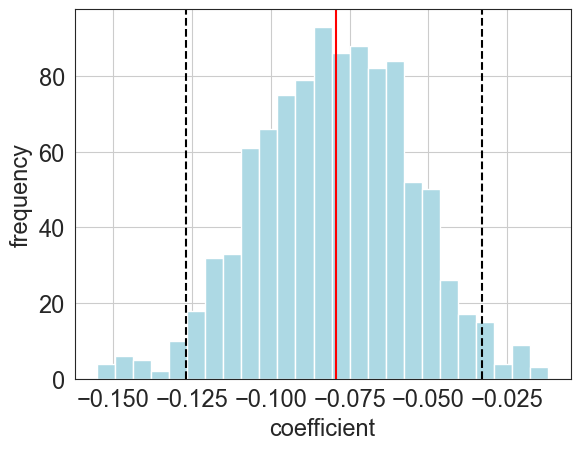

In [53]:
# plot the boostrapping distribution of coef values, including 95% CIs and the empirical value

fig, ax = plt.subplots()

ax.hist(bootstrapped_coefs, bins = 25, color = '#ADD9E4')

#ax.set_title('Bootstrap Distribution Coefs')

ax.set_xlabel('coefficient')

ax.set_ylabel('frequency')

ax.axvline(model2.params[-2], color = 'red')
ax.axvline(np.percentile(bootstrapped_coefs, 2.5), color = 'black', linestyle = '--')
ax.axvline(np.percentile(bootstrapped_coefs, 97.5), color = 'black', linestyle = '--')

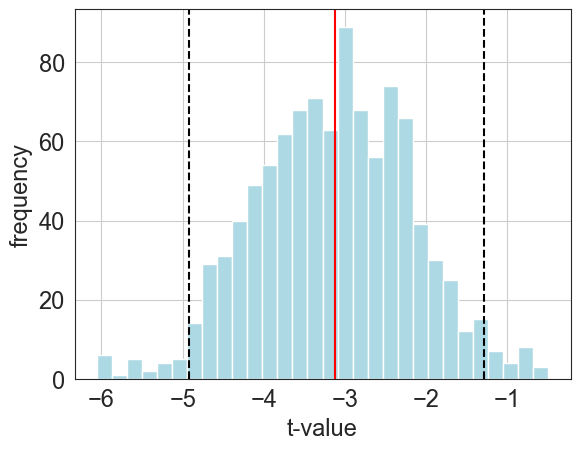

In [54]:
# plot the boostrapping distribution of coef values, including 95% CIs and the empirical value

fig, ax = plt.subplots()

ax.hist(bootstrapped_tvalues, bins = 30, color = '#ADD9E4')

#ax.set_title('Bootstrap Distribution Coefs')

ax.set_xlabel('t-value')

ax.set_ylabel('frequency')

ax.axvline(model2.tvalues[-2], color = 'red')
ax.axvline(np.percentile(bootstrapped_tvalues, 2.5), color = 'black', linestyle = '--')
ax.axvline(np.percentile(bootstrapped_tvalues, 97.5), color = 'black', linestyle = '--')

#plt.savefig(plotdir + 'BootstrappedTvalues.png', dpi = 1000)

In [55]:
X = BAGandMenDummiesPost[['ProbsPostresidAgeScanner', 'BAGresidAgeScanner']]
y = BAGandMenDummiesPost['pds_f6_y']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               pds_f6_y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.861
Date:                Tue, 20 Feb 2024   Prob (F-statistic):             0.0225
Time:                        11:46:24   Log-Likelihood:                -260.36
No. Observations:                 215   AIC:                             526.7
Df Residuals:                     212   BIC:                             536.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [56]:
pdsProbsPostBAG = 'pds_f6_y ~ BAGresidAgeScanner + ProbsPostresidAgeScanner'

model5 = smf.ols(formula=pdsProbsPostBAG, data=BAGandMenDummiesPost).fit()

In [57]:
summary5 = model5.summary()

In [58]:
print(pdsProbsPostBAG)
print(int(model5.nobs))
print('R2: ', model5.rsquared)#
print(model5.df_model, model5.df_resid)
print(summary5.tables[1])

pds_f6_y ~ BAGresidAgeScanner + ProbsPostresidAgeScanner
215
R2:  0.035142710163758695
2.0 212.0
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   11.1413      0.057    195.831      0.000      11.029      11.253
BAGresidAgeScanner          -0.0046      0.007     -0.653      0.514      -0.018       0.009
ProbsPostresidAgeScanner    -0.5358      0.228     -2.351      0.020      -0.985      -0.087


Text(0.5, 1.0, 'Brain Age Gap Distribution in ABCD Menarche Subjects')

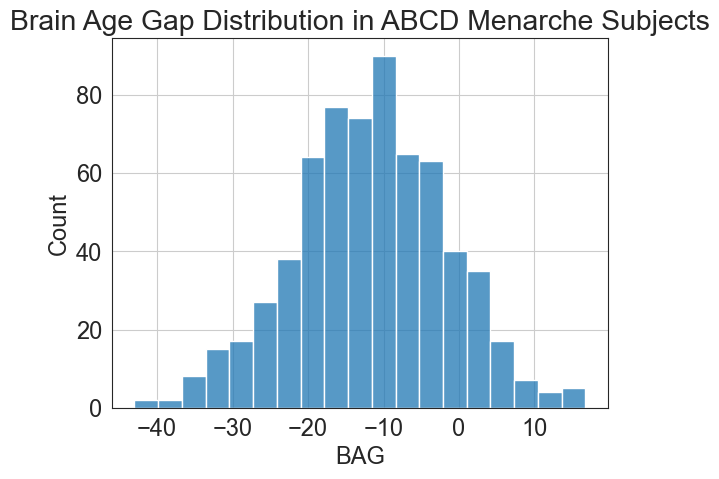

In [59]:
hist = sns.histplot(BAGandMenarche['BAG'])
hist.set_xlabel('BAG')
hist.set_title('Brain Age Gap Distribution in ABCD Menarche Subjects')
#plt.savefig('BAGhistFemaleModel.png', dpi = 1000)

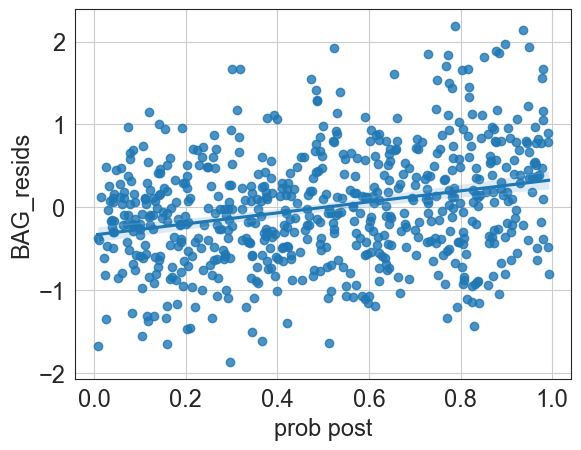

In [60]:
ax = sns.regplot(x = BAGandMenarche['prob post'], y = BAGandMenarche['BAG_resids']/12)
#plt.savefig('RegplotBAGresidsMenarche_Mixed.png', dpi = 1000)

In [61]:
dummies = BAGandMenDummiesPost.filter(regex=".*mri_info_deviceserialnumber.*").columns.to_list()
additionalcolumns = ['BAG_resids','age', 'pds_f6_y']
dummies.extend(additionalcolumns)

Text(0, 0.5, 'Menarche Classprobabilities controlled \n for Age and Scanner')

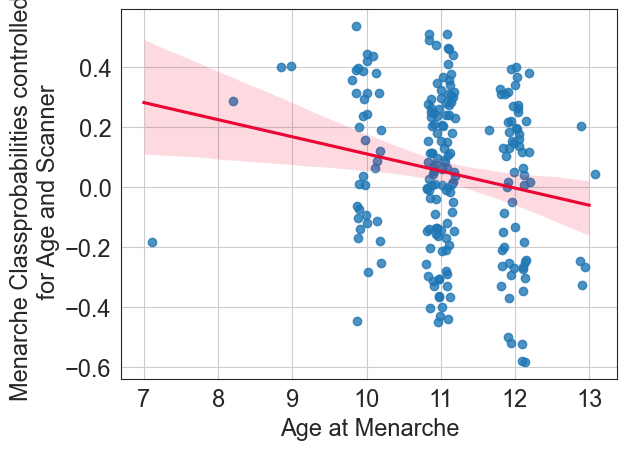

In [62]:
ax = sns.regplot(x = BAGandMenDummiesPost['pds_f6_y'], y = BAGandMenDummiesPost['ProbsPostresidAgeScanner'], x_ci='ci', x_jitter = 0.2,
            scatter=True, fit_reg=True, ci=95, line_kws={'color': '#eb0735'})

ax.set_xlabel('Age at Menarche')
ax.set_ylabel('Menarche Classprobabilities controlled \n for Age and Scanner')
#plt.savefig('RegplotAgeMenarcheClassprobs_Female.png', dpi = 1000)

# Include puberty categories in the analysis

In [65]:
pubcats = pd.read_csv('C:\\Users\\ninag\\Documents\\MasterarbeitPaper\\Paper\\processedData\\PubertyCats.csv')

In [66]:
pubcatsCaregiver = pd.read_csv('C:\\Users\\ninag\\Documents\\MasterarbeitPaper\\Paper\\processedData\\PubertyCatsCaregiver.csv')

In [67]:
pubcatsTest = pubcats[pubcats['subjectkey'].isin(BAGandMenDummies['subjectkey'])]

In [68]:
pubcatsTestCaregiver = pubcatsCaregiver[pubcatsCaregiver['subjectkey'].isin(BAGandMenDummies['subjectkey'])]

In [69]:
pubcatT = pubcatsTest[['subjectkey', 'gonadal', 'adrenal', 'PDS_mean', 'PDS_cat_score', 'PDS_category']].copy()

In [70]:
pubcatTC = pubcatsTestCaregiver[['subjectkey', 'gonadal', 'adrenal', 'PDS_mean', 'PDS_cat_score', 'PDS_category']].copy()

In [71]:
pubcatTC.rename(columns = {'gonadal' : 'gonadalC', 'adrenal' : 'adrenalC', 'PDS_mean' : 'PDS_meanC', 
                           'PDS_cat_score' : 'PDS_cat_scoreC', 'PDS_category' : 'PDS_categoryC'}, inplace = True)

In [72]:
MenPubBAG = BAGandMenDummiesExtended.merge(pubcatT.merge(pubcatTC, on = 'subjectkey', how = 'outer'),
                                                         on = 'subjectkey', how = 'outer')

In [73]:
def switch_case(pubcat):
    if pubcat == '':
        return None
    elif pubcat == 'prepubertal':
        return 1
    elif pubcat == 'early pubertal':
        return 2
    elif pubcat == 'midpubertal':
        return 3
    elif pubcat == 'late pubertal':
        return 4
    elif pubcat == 'postpubertal':
        return 5
    else:
        return None
    

In [74]:
# Apply the function to create 'Status' column
MenPubBAG['PDS_category_num'] = MenPubBAG['PDS_category'].apply(switch_case)
MenPubBAG['PDS_category_numC'] = MenPubBAG['PDS_categoryC'].apply(switch_case)

MenPubBAG.head()

,Unnamed: 0,prob pre,probsPost,subjectkey,Actual,Predicted,tpfptnfn,smri_area_cdk_banksstslh_M1,smri_area_cdk_cdacatelh_M1,smri_area_cdk_cdmdfrlh_M1,...,PDS_mean,PDS_cat_score,PDS_category,gonadalC,adrenalC,PDS_meanC,PDS_cat_scoreC,PDS_categoryC,PDS_category_num,PDS_category_numC
0,0,0.380606,0.619394,NDAR_INV00X2TBWJ,0,1,False Positive,1292.313296,738.946266,2327.094414,...,2.2,5.0,midpubertal,2.333333,2.5,2.4,6.0,midpubertal,3.0,3.0
1,1,0.507208,0.492792,NDAR_INV01RGTWD2,0,0,True Negative,1066.522023,596.749086,1736.336976,...,1.8,4.0,midpubertal,1.000000,2.5,1.6,4.0,midpubertal,3.0,3.0
2,2,0.107039,0.892961,NDAR_INV03NW0RKL,0,1,False Positive,1085.891591,516.479172,1972.597565,...,2.2,5.0,midpubertal,2.333333,3.0,2.6,6.0,midpubertal,3.0,3.0
3,3,0.578159,0.421841,NDAR_INV09VBPCLU,0,0,True Negative,771.604834,531.460468,2104.044714,...,NaN,NaN,NaN,2.333333,3.0,2.6,6.0,midpubertal,NaN,3.0
4,4,0.877560,0.122440,NDAR_INV0A9K5L4R,0,0,True Negative,1112.834469,534.485179,2362.506302,...,1.8,4.0,midpubertal,2.000000,2.0,2.0,4.0,midpubertal,3.0,3.0


In [75]:
print(MenPubBAG.isna().sum().to_string())

Unnamed: 0                                    0
prob pre                                      0
probsPost                                     0
subjectkey                                    0
Actual                                        0
Predicted                                     0
tpfptnfn                                      0
smri_area_cdk_banksstslh_M1                   0
smri_area_cdk_cdacatelh_M1                    0
smri_area_cdk_cdmdfrlh_M1                     0
smri_area_cdk_cuneuslh_M1                     0
smri_area_cdk_ehinallh_M1                     0
smri_area_cdk_fusiformlh_M1                   0
smri_area_cdk_ifpllh_M1                       0
smri_area_cdk_iftmlh_M1                       0
smri_area_cdk_ihcatelh_M1                     0
smri_area_cdk_locclh_M1                       0
smri_area_cdk_lobfrlh_M1                      0
smri_area_cdk_linguallh_M1                    0
smri_area_cdk_mobfrlh_M1                      0
smri_area_cdk_mdtmlh_M1                 

In [76]:
pubcatsBAG2 = 'BAG ~ PDS_category_num + age + C(scanner)'

model51 = smf.ols(formula=pubcatsBAG2, data=MenPubBAG, missing = 'drop').fit()

In [77]:
summary51 = model51.summary()

In [78]:
print(pubcatsBAG2)
print(int(model51.nobs))
print('R2: ', model51.rsquared)#
print(summary51.tables[1])

BAG ~ PDS_category_num + age + C(scanner)
631
R2:  0.3831729089820015
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    105.6848     10.213     10.348      0.000      85.628     125.742
C(scanner)[T.HASH03db707f]    -9.7817      8.384     -1.167      0.244     -26.247       6.684
C(scanner)[T.HASH11ad4ed5]    -2.2920      8.264     -0.277      0.782     -18.522      13.938
C(scanner)[T.HASH1314a204]    -5.4692      8.248     -0.663      0.508     -21.668      10.729
C(scanner)[T.HASH311170b9]    -7.5105      8.318     -0.903      0.367     -23.847       8.826
C(scanner)[T.HASH3935c89e]    -4.7704      8.202     -0.582      0.561     -20.879      11.338
C(scanner)[T.HASH4036a433]    -5.6688      8.384     -0.676      0.499     -22.134      10.796
C(scanner)[T.HASH4b0b8b05]   -10.4639      8.252     -1.268      0.205     

In [79]:
pubcatsBAGProbs_C = 'PDS_category_numC ~ BAGresidAgeScanner + ProbsPostresidAgeScanner'

model101 = smf.ols(formula=pubcatsBAGProbs_C, data=MenPubBAG, missing = 'drop').fit()

In [80]:
summary101 = model101.summary()

In [81]:
print(pubcatsBAGProbs_C)
print(int(model101.nobs))
print('R2: ', model101.rsquared)#
print(summary101.tables[1])

PDS_category_numC ~ BAGresidAgeScanner + ProbsPostresidAgeScanner
618
R2:  0.025084124459483048
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1611      0.034     91.892      0.000       3.094       3.229
BAGresidAgeScanner           0.0048      0.005      1.058      0.290      -0.004       0.014
ProbsPostresidAgeScanner     0.4407      0.131      3.367      0.001       0.184       0.698


In [82]:
pubcatsBAGProbs_Y = 'PDS_category_num ~ BAGresidAgeScanner + ProbsPostresidAgeScanner'

model102 = smf.ols(formula=pubcatsBAGProbs_Y, data=MenPubBAG, missing = 'drop').fit()

In [83]:
summary102 = model102.summary()

In [84]:
print(pubcatsBAGProbs_Y)
print(int(model102.nobs))
print('R2: ', model102.rsquared)#
print(summary102.tables[1])

PDS_category_num ~ BAGresidAgeScanner + ProbsPostresidAgeScanner
631
R2:  0.02221053172973053
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1273      0.035     90.319      0.000       3.059       3.195
BAGresidAgeScanner           0.0042      0.005      0.922      0.357      -0.005       0.013
ProbsPostresidAgeScanner     0.4268      0.132      3.234      0.001       0.168       0.686


In [85]:
pubcatsBAG_C2 = 'BAG ~ PDS_category_numC + age + C(scanner)'

model61 = smf.ols(formula=pubcatsBAG_C2, data=MenPubBAG, missing = 'drop').fit()

In [86]:
summary61 = model61.summary()

In [87]:
print(pubcatsBAG_C2)
print(int(model61.nobs))
print('R2: ', model61.rsquared)
print(summary61.tables[1])

BAG ~ PDS_category_numC + age + C(scanner)
618
R2:  0.38627013151809886
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    104.1993      8.414     12.384      0.000      87.674     120.725
C(scanner)[T.HASH03db707f]   -10.4574      6.131     -1.706      0.089     -22.498       1.584
C(scanner)[T.HASH11ad4ed5]    -3.1175      5.920     -0.527      0.599     -14.745       8.510
C(scanner)[T.HASH1314a204]    -5.4200      5.917     -0.916      0.360     -17.041       6.201
C(scanner)[T.HASH311170b9]    -8.1331      6.007     -1.354      0.176     -19.930       3.664
C(scanner)[T.HASH3935c89e]    -5.7393      5.848     -0.981      0.327     -17.226       5.747
C(scanner)[T.HASH4036a433]    -6.1535      6.151     -1.000      0.318     -18.234       5.927
C(scanner)[T.HASH4b0b8b05]   -11.2103      5.929     -1.891      0.059   

In [88]:
pubcatsProbsPost2 = 'probsPost ~ PDS_category_num + age + C(scanner)'

model71 = smf.ols(formula=pubcatsProbsPost2, data=MenPubBAG, missing = 'drop').fit()

In [89]:
summary71 = model71.summary()

In [90]:
print(pubcatsProbsPost2)
print(int(model71.nobs))
print(model71.df_model, model71.df_resid)
print('R2: ', model71.rsquared)
print(summary71.tables[1])

probsPost ~ PDS_category_num + age + C(scanner)
631
28.0 602.0
R2:  0.0932003402923749
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.5881      0.349     -1.687      0.092      -1.273       0.097
C(scanner)[T.HASH03db707f]     0.0607      0.286      0.212      0.832      -0.501       0.623
C(scanner)[T.HASH11ad4ed5]    -0.0195      0.282     -0.069      0.945      -0.574       0.535
C(scanner)[T.HASH1314a204]    -0.0166      0.282     -0.059      0.953      -0.570       0.536
C(scanner)[T.HASH311170b9]     0.0488      0.284      0.172      0.864      -0.509       0.606
C(scanner)[T.HASH3935c89e]     0.0587      0.280      0.210      0.834      -0.491       0.609
C(scanner)[T.HASH4036a433]     0.0497      0.286      0.174      0.862      -0.512       0.612
C(scanner)[T.HASH4b0b8b05]    -0.0339      0.282     -0.12

In [91]:
pubcatsProbsPost2_C = 'probsPost ~ PDS_category_numC + age + C(scanner)'

model81 = smf.ols(formula=pubcatsProbsPost2_C, data=MenPubBAG, missing = 'drop').fit()

In [92]:
summary81 = model81.summary()

In [93]:
print(pubcatsProbsPost2_C)
print(int(model81.nobs))
print('R2: ', model81.rsquared)#
print(summary81.tables[1])

probsPost ~ PDS_category_numC + age + C(scanner)
618
R2:  0.10071859566858632
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.6326      0.288     -2.195      0.029      -1.199      -0.067
C(scanner)[T.HASH03db707f]     0.0420      0.210      0.200      0.842      -0.370       0.454
C(scanner)[T.HASH11ad4ed5]    -0.0868      0.203     -0.428      0.669      -0.485       0.312
C(scanner)[T.HASH1314a204]    -0.0544      0.203     -0.268      0.789      -0.452       0.344
C(scanner)[T.HASH311170b9]    -0.0240      0.206     -0.117      0.907      -0.428       0.380
C(scanner)[T.HASH3935c89e]    -0.0066      0.200     -0.033      0.974      -0.400       0.387
C(scanner)[T.HASH4036a433]     0.0153      0.211      0.073      0.942      -0.398       0.429
C(scanner)[T.HASH4b0b8b05]    -0.0813      0.203     -0.400      0.

In [94]:
MenPubBAG.rename(columns = {'pds_f6_y':'ageMenarche', 'interview_age_M1':'age','PDS_category_num':'PMDS_Youth',
                            'PDS_category_numC':'PMDS_Caregiver'}, inplace = True)

# Controlling Classprobabilites by Age at Menarche Association for SES, BMI and race

In [115]:
ethno = pd.read_csv('C:\\Users\\ninag\\Documents\\MasterarbeitPaper\\Paper\\processedData\\SESBMIrace.csv')

In [116]:
ethno_reduced = ethno[ethno['subjectkey'].isin(MenPubBAG['subjectkey'])]

In [117]:
BAGMenEth = pd.merge(ethno_reduced, MenPubBAG, how = 'outer', on = 'subjectkey')

In [118]:
BAGMenEth.sort_values(by = 'subjectkey', inplace = True)

In [119]:
BAGMenEth.reset_index(drop = True, inplace = True)

In [120]:
BAGMenEth.rename(columns = {'interview_age_M1':'age'}, inplace = True)

In [121]:
temp100 = 'ProbsPostresidAgeScanner ~ BAGresidAgeScanner + bmi + ses + C(ethno)'

modelDemog1 = smf.ols(formula=temp100, data=BAGMenEth).fit()

In [122]:
summary100 = modelDemog1.summary()

In [123]:
print(temp100)
print(int(modelDemog1.nobs))
print(modelDemog1.df_model, modelDemog1.df_resid)
print('R2: ', modelDemog1.rsquared)#
print(summary100.tables[1])

ProbsPostresidAgeScanner ~ BAGresidAgeScanner + bmi + ses + C(ethno)
546
7.0 538.0
R2:  0.1907722477363989
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1257      0.082      1.524      0.128      -0.036       0.288
C(ethno)[T.black]       -0.0815      0.079     -1.026      0.306      -0.238       0.075
C(ethno)[T.hispanic]    -0.1980      0.075     -2.647      0.008      -0.345      -0.051
C(ethno)[T.other]       -0.2279      0.079     -2.895      0.004      -0.383      -0.073
C(ethno)[T.white]       -0.2880      0.071     -4.038      0.000      -0.428      -0.148
BAGresidAgeScanner       0.0093      0.001      6.897      0.000       0.007       0.012
bmi                      0.0051      0.002      2.130      0.034       0.000       0.010
ses                     -0.0293      0.016     -1.880      0.061      -0.060       0.001


In [124]:
BAGMenEth['ethnoTemp'] = BAGMenEth['ethno'].copy()

In [125]:
BAGMenEth = pd.get_dummies(BAGMenEth, columns=['ethno'], dtype = int)

In [126]:
dummiesRace = BAGMenEth.filter(regex=".*ethno_.*").columns.to_list()
additionalcolumns = ['bmi','ses','BAGresidAgeScanner']
dummiesRace.extend(additionalcolumns)

X = BAGMenEth[dummiesRace]
y = BAGMenEth['ProbsPostresidAgeScanner']

X = sm.add_constant(X)

model = sm.OLS(y,X, missing = 'drop')
results = model.fit()

print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     ProbsPostresidAgeScanner   R-squared:                       0.191
Model:                                  OLS   Adj. R-squared:                  0.180
Method:                       Least Squares   F-statistic:                     18.12
Date:                      Tue, 20 Feb 2024   Prob (F-statistic):           1.12e-21
Time:                              11:52:22   Log-Likelihood:                -16.571
No. Observations:                       546   AIC:                             49.14
Df Residuals:                           538   BIC:                             83.56
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [127]:
dummiesRace = BAGMenEth.filter(regex=".*ethno_.*").columns.to_list()
dummies2 = BAGMenEth.filter(regex=".*mri_info_deviceserialnumber.*").columns.to_list()
additionalcolumns = ['age','bmi','ses','ageMenarche']
dummiesRace.extend(additionalcolumns)
dummiesRace.extend(dummies2)

X = BAGMenEth[dummiesRace]
y = BAGMenEth['probsPost']

X = sm.add_constant(X)

model = sm.OLS(y,X, missing = 'drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              probsPost   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.823
Date:                Tue, 20 Feb 2024   Prob (F-statistic):            0.00997
Time:                        11:52:26   Log-Likelihood:                 11.161
No. Observations:                 174   AIC:                             41.68
Df Residuals:                     142   BIC:                             142.8
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [128]:
dummiesRace = BAGMenEth.filter(regex=".*ethno_.*").columns.to_list()
dummies2 = BAGMenEth.filter(regex=".*mri_info_deviceserialnumber.*").columns.to_list()
additionalcolumns = ['age','bmi','ses','PDS_cat_score']
dummiesRace.extend(additionalcolumns)
dummiesRace.extend(dummies2)

X = BAGMenEth[dummiesRace]
y = BAGMenEth['probsPost']

X = sm.add_constant(X)

model = sm.OLS(y,X, missing = 'drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              probsPost   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     4.182
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.04e-12
Time:                        11:52:30   Log-Likelihood:                -25.370
No. Observations:                 531   AIC:                             118.7
Df Residuals:                     497   BIC:                             264.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [129]:
dummiesRace = BAGMenEth.filter(regex=".*ethno_.*").columns.to_list()
dummies2 = BAGMenEth.filter(regex=".*mri_info_deviceserialnumber.*").columns.to_list()
additionalcolumns = ['age','bmi','ses','PDS_cat_scoreC']
dummiesRace.extend(additionalcolumns)
dummiesRace.extend(dummies2)

X = BAGMenEth[dummiesRace]
y = BAGMenEth['probsPost']

X = sm.add_constant(X)

model = sm.OLS(y,X, missing = 'drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              probsPost   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.326
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           2.58e-13
Time:                        11:52:32   Log-Likelihood:                -23.940
No. Observations:                 524   AIC:                             115.9
Df Residuals:                     490   BIC:                             260.8
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [130]:
temp102 = 'probsPost ~ ageMenarche + age + bmi + ses + C(ethnoTemp) + C(scanner)'

modelDemog2 = smf.ols(formula=temp102, data=BAGMenEth, missing = 'drop').fit()

In [131]:
summary102 = modelDemog2.summary()

In [132]:
print(temp102)
print(int(modelDemog2.nobs))
print(modelDemog2.df_model, modelDemog2.df_resid)
print('R2: ', modelDemog2.rsquared)#
print(summary102.tables[1])

probsPost ~ ageMenarche + age + bmi + ses + C(ethnoTemp) + C(scanner)
174
31.0 142.0
R2:  0.28465290728694226
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1318      0.499     -2.269      0.025      -2.118      -0.146
C(ethnoTemp)[T.black]          0.2158      0.164      1.314      0.191      -0.109       0.541
C(ethnoTemp)[T.hispanic]       0.1236      0.153      0.807      0.421      -0.179       0.427
C(ethnoTemp)[T.other]         -0.0049      0.157     -0.031      0.975      -0.316       0.306
C(ethnoTemp)[T.white]         -0.0188      0.146     -0.129      0.898      -0.308       0.270
C(scanner)[T.HASH03db707f]    -0.0204      0.120     -0.171      0.865      -0.257       0.216
C(scanner)[T.HASH11ad4ed5]    -0.0162      0.095     -0.170      0.865      -0.205       0.173
C(scanner)[T.HASH1314a204]    -0.07

In [135]:
temp103 = 'probsPost ~ PDS_cat_score + age + bmi + ses + C(ethnoTemp) + C(scanner)'

modelDemog3 = smf.ols(formula=temp103, data=BAGMenEth, missing = 'drop').fit()

In [136]:
summary103 = modelDemog3.summary()

In [137]:
print(temp103)
print(int(modelDemog3.nobs))
print(modelDemog3.df_model, modelDemog3.df_resid)
print('R2: ', modelDemog3.rsquared)#
print(summary103.tables[1])

probsPost ~ PDS_cat_score + age + bmi + ses + C(ethnoTemp) + C(scanner)
531
33.0 497.0
R2:  0.21734210494161887
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.4609      0.241     -1.914      0.056      -0.934       0.012
C(ethnoTemp)[T.black]         -0.0831      0.092     -0.903      0.367      -0.264       0.098
C(ethnoTemp)[T.hispanic]      -0.1695      0.085     -1.991      0.047      -0.337      -0.002
C(ethnoTemp)[T.other]         -0.2520      0.088     -2.848      0.005      -0.426      -0.078
C(ethnoTemp)[T.white]         -0.3503      0.081     -4.305      0.000      -0.510      -0.190
C(scanner)[T.HASH03db707f]    -0.0056      0.092     -0.061      0.952      -0.186       0.175
C(scanner)[T.HASH11ad4ed5]     0.0035      0.051      0.068      0.946      -0.097       0.104
C(scanner)[T.HASH1314a204]    -0.

In [138]:
temp103 = 'probsPost ~ PDS_cat_scoreC + age + bmi + ses + C(ethnoTemp) + C(scanner)'

modelDemog3 = smf.ols(formula=temp103, data=BAGMenEth, missing = 'drop').fit()

In [139]:
summary103 = modelDemog3.summary()

In [140]:
print(temp103)
print(int(modelDemog3.nobs))
print(modelDemog3.df_model, modelDemog3.df_resid)
print('R2: ', modelDemog3.rsquared)#
print(summary103.tables[1])

probsPost ~ PDS_cat_scoreC + age + bmi + ses + C(ethnoTemp) + C(scanner)
524
33.0 490.0
R2:  0.225631717394149
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.4121      0.244     -1.686      0.092      -0.892       0.068
C(ethnoTemp)[T.black]         -0.1082      0.094     -1.147      0.252      -0.293       0.077
C(ethnoTemp)[T.hispanic]      -0.1789      0.088     -2.041      0.042      -0.351      -0.007
C(ethnoTemp)[T.other]         -0.2694      0.091     -2.963      0.003      -0.448      -0.091
C(ethnoTemp)[T.white]         -0.3589      0.084     -4.290      0.000      -0.523      -0.195
C(scanner)[T.HASH03db707f]     0.0028      0.092      0.031      0.976      -0.178       0.183
C(scanner)[T.HASH11ad4ed5]    -0.0013      0.051     -0.025      0.980      -0.101       0.099
C(scanner)[T.HASH1314a204]    -0.0

# Plots

C:\Users\ninag\AppData\Local\Temp\ipykernel_12736\1435159470.py:3: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace = 0.3, bottom = 0.2)


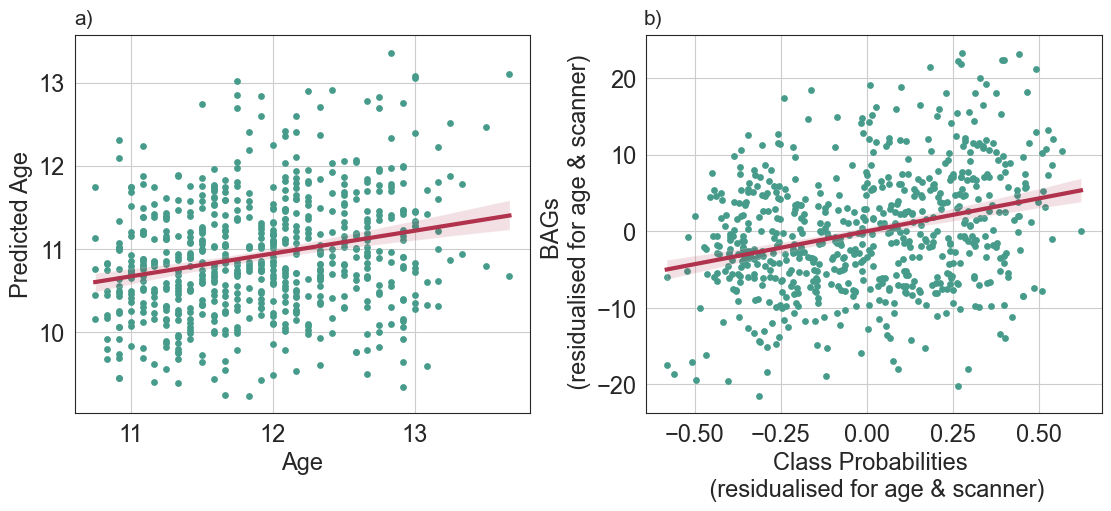

In [141]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [11,5], constrained_layout = True)
#fig.tight_layout(pad = 2.1)
plt.subplots_adjust(wspace = 0.3, bottom = 0.2)

x1 = BAGandMenDummies['age']/12
y1 = BAGandMenDummies['predictedAge']/12

x2 = BAGandMenDummies['ProbsPostresidAgeScanner']
y2 = BAGandMenDummies['BAGresidAgeScanner']


sns.regplot(x = x1, y = y1, ax = ax1,
#     data=combined_noOutliers[combined_noOutliers['actual_cat'] == 'pre'], 
#                 x='probsPost', y='P1', x_ci='ci', scatter=True,
#                 fit_reg=True, ci=95, n_boot=1000, seed=100, truncate=True,
                 scatter_kws={'color': '#469B8A', 'alpha': 1, 's': 15}, line_kws={'color': '#B0324C','linewidth': 3})

#axes_range = [8.5, 13.5] 
#plt.xlim(axes_range)
#plt.ylim(axes_range)
#ax2.set_aspect('equal', adjustable='box')
ax1.text(10.6, 13.7, "a)", fontsize=15)
ax1.set_xlabel('Age')
ax1.set_ylabel('Predicted Age')


sns.regplot(x = x2, y = y2, ax = ax2,
#     data=combined_noOutliers[combined_noOutliers['actual_cat'] == 'pre'], 
#                 x='probsPost', y='P1', x_ci='ci', scatter=True,
#                 fit_reg=True, ci=95, n_boot=1000, seed=100, truncate=True,
                 scatter_kws={'color': '#469B8A', 'alpha': 1, 's': 15}, line_kws={'color': '#B0324C','linewidth': 3})

#ax1.set_aspect('equal', adjustable='box')
ax2.text(-0.65, 27, "b)", fontsize=15)
ax2.set_xlabel('Class Probabilities \n (residualised for age & scanner)')
ax2.set_ylabel('BAGs \n (residualised for age & scanner)')

plt.savefig('C:\\Users\\ninag\\Documents\\MasterarbeitPaper\\Paper\\Plots\\Figure3.png', dpi = 1000)

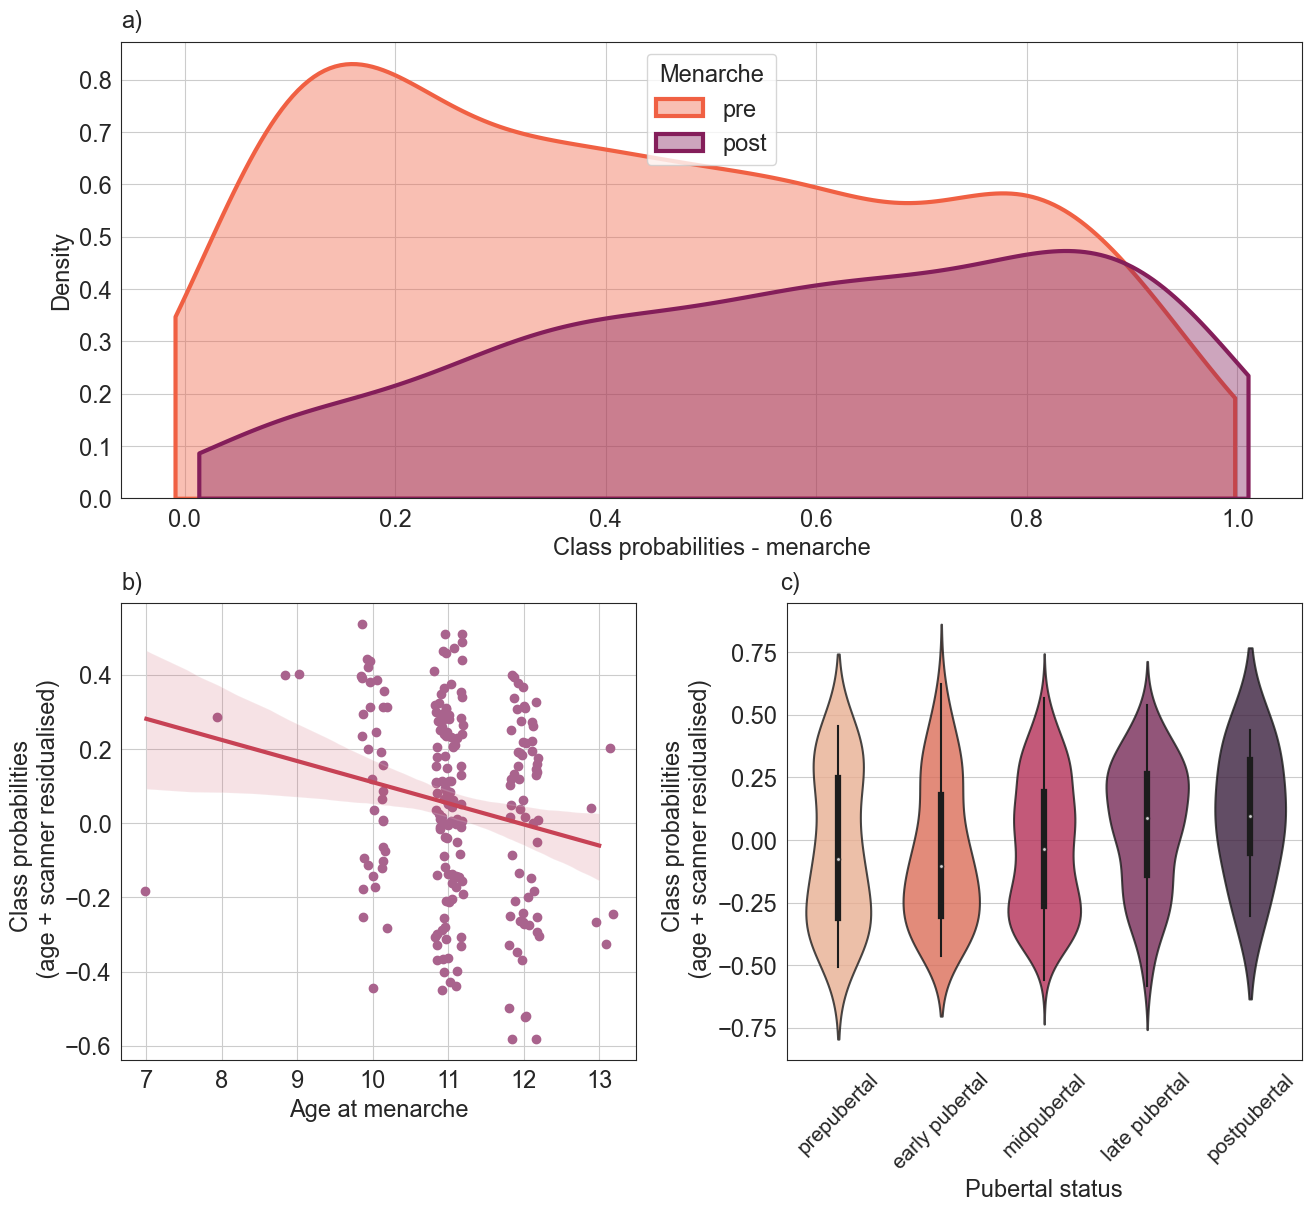

In [147]:
fig = plt.figure(constrained_layout=True, figsize = (13,12))
#fig3.tight_layout(pad = 5)


gs = fig.add_gridspec(2, 2)#, width_ratios = [1,1], height_ratios = [1,1])
#plt.subplots_adjust(wspace=None, hspace=0.1)


ax3 = fig.add_subplot(gs[0, :])

dens = sns.kdeplot(
   data=BAGandMenDummies, x="probsPost", hue="Actual",
   cut = 0.2, fill=True, multiple = 'layer', palette="rocket",
   alpha=0.4, linewidth=3, hue_order=[1,0], ax=ax3,
    legend = False
)

ax3.set_xlabel('Class probabilities - menarche')
#ax3.set_xlabel('Classprobabilites of \'Post Menarche\' Classification')
ax3.legend(title = 'Menarche',labels = ['pre','post'], loc = 'upper center')
ax3.text(-0.06, 0.9, "a)", fontsize=17)



ax1 = fig.add_subplot(gs[1, 0])

sns.regplot(x = BAGandMenDummiesPost['pds_f6_y'], y = BAGandMenDummiesPost['ProbsPostresidAgeScanner'], x_ci='ci', x_jitter = 0.2,
            scatter=True, fit_reg=True, ci=95, scatter_kws = {'color': '#A9638D', 'alpha': 1},
            line_kws={'color': '#C74255', 'linewidth':3}, ax = ax1)

ax1.set_xlabel('Age at menarche')
ax1.set_ylabel('Class probabilities \n (age + scanner residualised)')#controlled \n for Age and Scanner')
ax1.text(6.67, 0.63, "b)", fontsize=17)


ax2 = fig.add_subplot(gs[1, 1])

sns.violinplot(x = MenPubBAG['PMDS_Youth'], y = BAGandMenDummies['ProbsPostresidAgeScanner'], 
               palette = 'rocket_r', ax = ax2, violinprops=dict(alpha=.5))
plt.setp(ax2.collections, alpha=.8)

ax2.set_xlabel('Pubertal status')
ax2.set_ylabel('Class probabilities \n (age + scanner residualised)')#controlled \n for Age and Scanner')
#ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['prepubertal', 'early pubertal', 'midpubertal','late pubertal', 'postpubertal'], 
                    fontsize = 15, rotation = 45)
ax2.text(-0.56, 1, "c)", fontsize=17)



#plt.savefig('Plots\\SuplotsKDEaAgeatMenPubCatViolinSwitched1902.pdf', dpi = 1000)
plt.savefig('Plots\\Figure2.pdf', dpi = 1000)